# E-03 고양이 수염 프로젝트 만들기

### 라이브러리 가져오기

In [23]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

### 내 이미지 불러오기

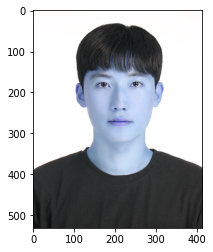

In [24]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image1.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

### opencv는 BGR을 가지고 있어 RGB로 바꿔준다.

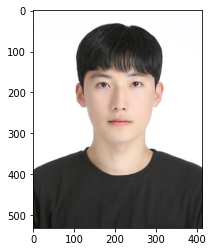

In [25]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### dlib을 활용해 hog detector를 선언한다

In [26]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

### detector_hog를 통해 얼굴의 bounding box를 추출
### dlib은 이미지 RGB값만 받기 때문에 BGR에서 RGB로 바꿔준다 ---(1)

In [42]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #---(1)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid) --(이미지, 이미지 피라미드의 수)

### dlib detector 는 dlib.rectangles 타입의 객체를 반환 dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있습니다.  
  
### dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있습니다.   

rectangles[[(118, 139) (304, 325)]]


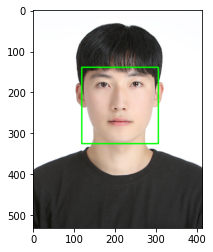

In [28]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### landmark 모델 불러오기

In [29]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

### 68개의 얼굴 랜드마크 

In [30]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### 68개의 랜드마크를 이미지상에 보여주기

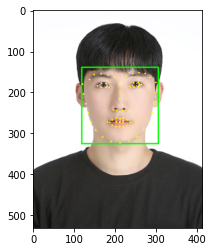

In [31]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 코 위치 좌표 저장

In [35]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] 
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(210, 233)
(x,y) : (210,233)
(w,h) : (187,187)


스티커 사진 크기 조정

(512, 512, 3)
(187, 187, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

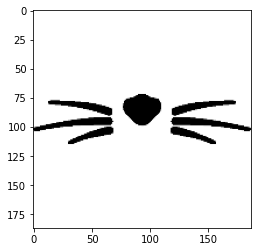

In [36]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
print(img_sticker.shape) #스티커 원본 크기 확인
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 크기 조정
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show

### 스티커를 이미지상에 놓을 위치 계산 후 저장

In [37]:
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (117,140)


### 스티커가 이미지안에서 벗어날 경우 벗어난 공간을 0처리
즉 음수 값을 0값으로 치환

In [38]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (117,140)


### 스티커를 이미지안에 넣기

In [39]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

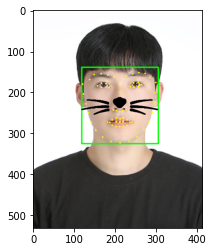

In [40]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### landmark와 bounding box 없애고 스티커와 이미지만 남기기

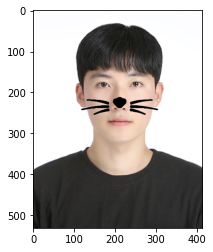

In [41]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()